In [12]:
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import shap
import kds

from sklearn import metrics
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, r2_score, f1_score, make_scorer, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.inspection import permutation_importance, plot_partial_dependence,partial_dependence,PartialDependenceDisplay

In [13]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 100

In [14]:
lead_acs = pd.read_csv("../data/model/all_lead_acs_model.csv")

In [15]:
target_name = "IS_CONVERTED"
# target = lead_acs[target_name]
# data = lead_acs.drop(columns=[target_name])

In [16]:
status_col = [col for col in lead_acs.columns if col.startswith("STATUS")]

In [17]:
target_name = "IS_CONVERTED"
target = lead_acs[target_name]
data = lead_acs.drop(columns= status_col + [target_name] + ["LEVEL_VETTING_C"])

In [18]:
# data_d_level = data.drop(columns = "LEVEL_VETTING_C")

# Train Test Validation Split

In [19]:
 X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=1)
 X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [20]:
X_train.head()

,ID,HAS_OPTED_OUT_OF_EMAIL,Percent!!HOUSEHOLDS BY TYPE!!Total households!!Married-couple household,Percent!!HOUSEHOLDS BY TYPE!!Total households!!Cohabiting couple household,"Percent!!HOUSEHOLDS BY TYPE!!Total households!!Male householder, no spouse/partner present","Percent!!HOUSEHOLDS BY TYPE!!Total households!!Male householder, no spouse/partner present!!Householder living alone","Percent!!HOUSEHOLDS BY TYPE!!Total households!!Male householder, no spouse/partner present!!Householder living alone!!65 years and over","Percent!!HOUSEHOLDS BY TYPE!!Total households!!Female householder, no spouse/partner present","Percent!!HOUSEHOLDS BY TYPE!!Total households!!Female householder, no spouse/partner present!!Householder living alone","Percent!!HOUSEHOLDS BY TYPE!!Total households!!Female householder, no spouse/partner present!!Householder living alone!!65 years and over",Percent!!HOUSEHOLDS BY TYPE!!Total households!!Households with one or more people under 18 years,Percent!!HOUSEHOLDS BY TYPE!!Total households!!Households with one or more people 65 years and over,Percent!!RELATIONSHIP!!Population in households!!Householder,Percent!!RELATIONSHIP!!Population in households!!Spouse,Percent!!RELATIONSHIP!!Population in households!!Unmarried partner,Percent!!RELATIONSHIP!!Population in households!!Child,Percent!!RELATIONSHIP!!Population in households!!Other relatives,Percent!!RELATIONSHIP!!Population in households!!Other nonrelatives,Percent!!MARITAL STATUS!!Males 15 years and over!!Never married,"Percent!!MARITAL STATUS!!Males 15 years and over!!Now married, except separated",Percent!!MARITAL STATUS!!Males 15 years and over!!Separated,Percent!!MARITAL STATUS!!Males 15 years and over!!Widowed,Percent!!MARITAL STATUS!!Males 15 years and over!!Divorced,Percent!!MARITAL STATUS!!Females 15 years and over!!Never married,"Percent!!MARITAL STATUS!!Females 15 years and over!!Now married, except separated",Percent!!MARITAL STATUS!!Females 15 years and over!!Separated,Percent!!MARITAL STATUS!!Females 15 years and over!!Widowed,Percent!!MARITAL STATUS!!Females 15 years and over!!Divorced,"Percent!!FERTILITY!!Number of women 15 to 50 years old who had a birth in the past 12 months!!Unmarried women (widowed, divorced, and never married)",Percent!!GRANDPARENTS!!Number of grandparents living with own grandchildren under 18 years!!Years responsible for grandchildren!!Less than 1 year,Percent!!GRANDPARENTS!!Number of grandparents living with own grandchildren under 18 years!!Years responsible for grandchildren!!1 or 2 years,Percent!!GRANDPARENTS!!Number of grandparents living with own grandchildren under 18 years!!Years responsible for grandchildren!!3 or 4 years,Percent!!GRANDPARENTS!!Number of grandparents living with own grandchildren under 18 years!!Years responsible for grandchildren!!5 or more years,Percent!!GRANDPARENTS!!Number of grandparents responsible for own grandchildren under 18 years!!Who are female,"Percent!!SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school, preschool",Percent!!SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,Percent!!SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),Percent!!SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),Percent!!SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Less than 9th grade,"Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!9th to 12th grade, no diploma",Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency),"Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college, no degree",Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Associate's degree,Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree,Percent!!EDUCATI

In [21]:
X_train.merge(lead_acs[["ID"]],left_index=True, right_index=True).query("LEAD_SOURCE_NDA == 1").sample(n = 20, random_state = 1)["ID"].to_list()

KeyError: 'ID'

In [ ]:
X_train_id.query("LEAD_SOURCE_NDA == 1")

# Model

## Base XGBoost

In [22]:
base_model = XGBClassifier(n_jobs=-1)
base_model.fit(X_train, y_train)

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:ID

In [ ]:
pred_train_y = base_model.predict(X_train)
fpr_train, tpr_train, thresholds = metrics.roc_curve(y_train, pred_train_y)
auc_train = metrics.auc(fpr_train, tpr_train)
recall_train = metrics.recall_score(y_train, pred_train_y)
precision_train = metrics.precision_score(y_train, pred_train_y)
accuracy_train = metrics.accuracy_score(y_train, pred_train_y)
f1_train = metrics.f1_score(y_train, pred_train_y,average='weighted')


cm = confusion_matrix(y_train, pred_train_y)

TN, FP, FN, TP = confusion_matrix(y_train, pred_train_y).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)
print(" ")
print("Train AUC: ",round(auc_train,4))
print("Train recall: ",round(recall_train,4))
print("Train precision: ",round(precision_train, 4))
print("Train accuracy: ",round(accuracy_train,4))
print("Train F1-score: ",round(f1_train, 4))

True Positive(TP)  =  3455
False Positive(FP) =  1067
True Negative(TN)  =  6075
False Negative(FN) =  2254
 
Train AUC:  0.7279
Train recall:  0.6052
Train precision:  0.764
Train accuracy:  0.7416
Train F1-score:  0.7365


In [ ]:
pred_test_y = base_model.predict(X_test)
fpr_test, tpr_test, thresholds = metrics.roc_curve(y_test, pred_test_y)
auc_test = metrics.auc(fpr_test, tpr_test)
recall_test = metrics.recall_score(y_test, pred_test_y)
precision_test = metrics.precision_score(y_test, pred_test_y)
accuracy_test = metrics.accuracy_score(y_test, pred_test_y)
f1_test = metrics.f1_score(y_test, pred_test_y,average='weighted')

cm = confusion_matrix(y_test, pred_test_y)

TN, FP, FN, TP = confusion_matrix(y_test, pred_test_y).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)
print(" ")
print("Test AUC: ",round(auc_test,4))
print("Test recall: ",round(recall_test,4))
print("Test precision: ",round(precision_test, 4))
print("Test accuracy: ",round(accuracy_test,4))
print("Test F1-score: ",round(f1_test, 4))

True Positive(TP)  =  1087
False Positive(FP) =  393
True Negative(TN)  =  1982
False Negative(FN) =  822
 
Test AUC:  0.702
Test recall:  0.5694
Test precision:  0.7345
Test accuracy:  0.7164
Test F1-score:  0.7102


In [ ]:
plt.rcParams["figure.figsize"] = (10,8)
plt.style.use('seaborn-darkgrid')

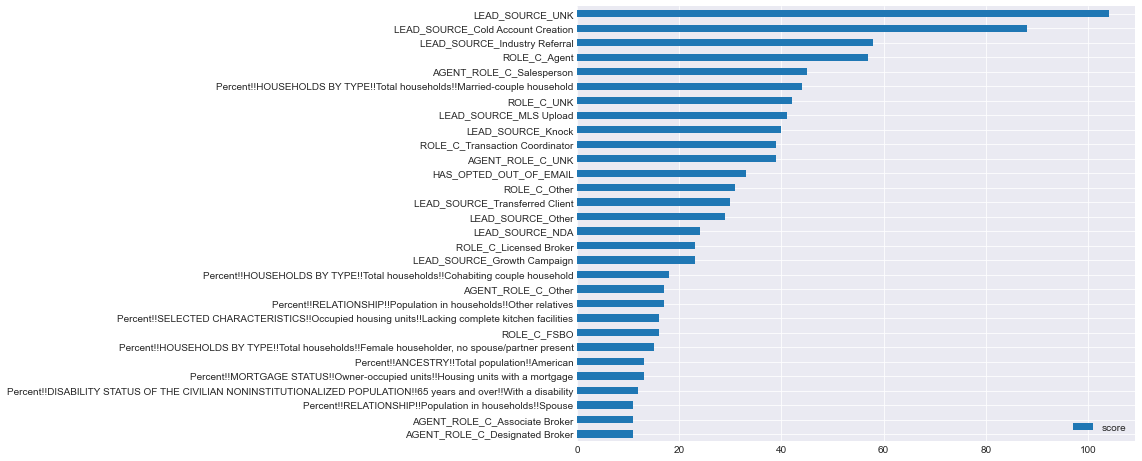

<Figure size 1440x2160 with 0 Axes>

In [ ]:
feature_important = base_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
# sns.set(rc={'figure.figsize':(13.7,10.27)})
feature_imp = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
ax = feature_imp.head(30).plot(kind='barh')
ax.invert_yaxis()
plt.figure(figsize=(20,30))
plt.show()

--- 91.81287980079651 seconds ---


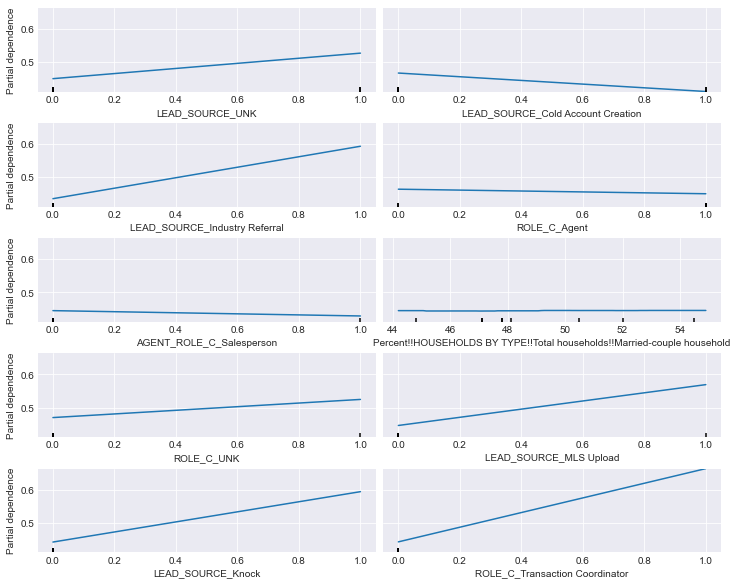

<Figure size 1440x1440 with 0 Axes>

In [ ]:
start_time = time.time()
fig, ax = plt.subplots(5, 2, constrained_layout=True)
fig = PartialDependenceDisplay.from_estimator(base_model, X_train, feature_imp.head(10).index.to_list(), ax=ax, n_jobs=-1)
print("--- %s seconds ---" % (time.time() - start_time))
# plt.rcParams["figure.figsize"] = (20,10)
plt.figure(figsize=(20,20))
plt.show()

In [ ]:
# plot_importance(base_model, importance_type = 'gain') # other options available
# plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


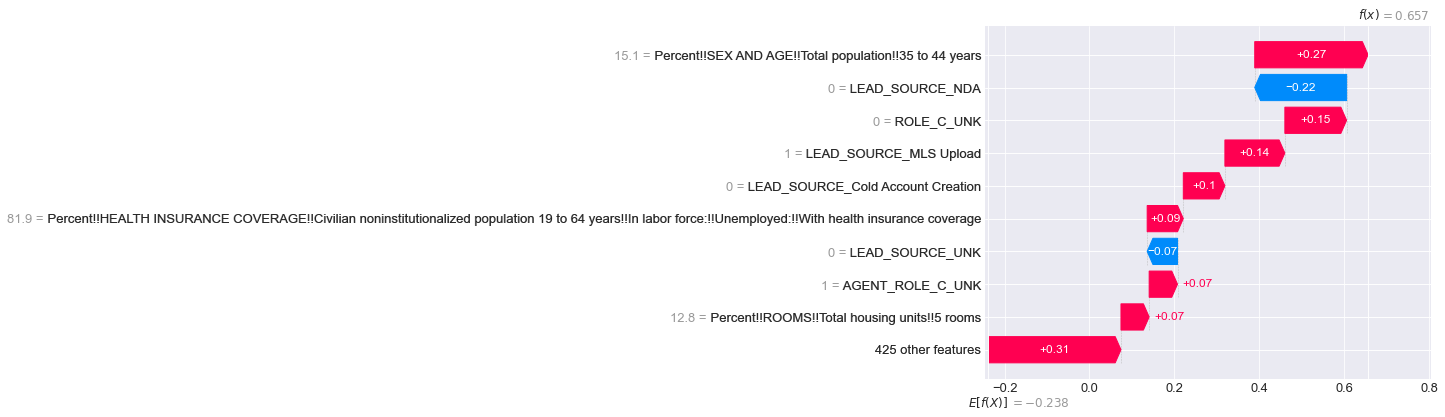

In [ ]:
explainer = shap.Explainer(base_model)
shap_values = explainer(X_test)

# visualize the first prediction's explanation

shap.plots.waterfall(shap_values[0])

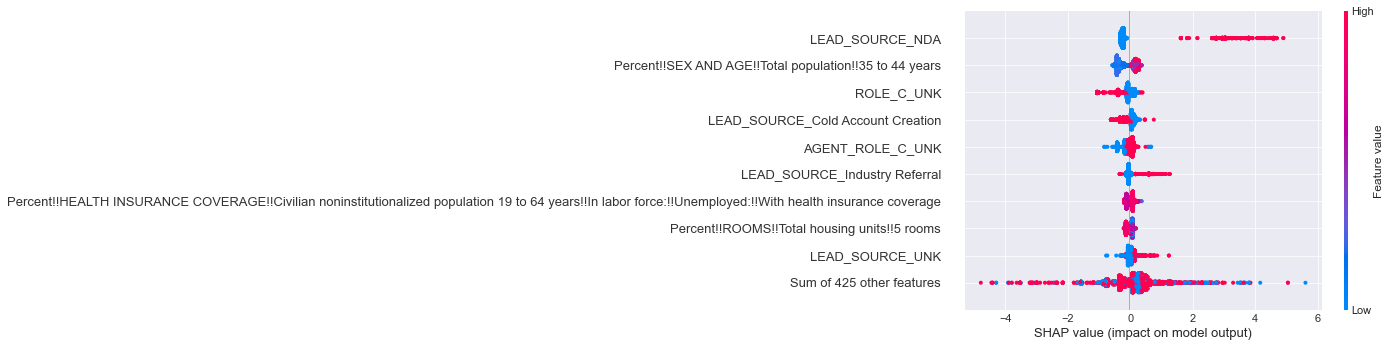

In [ ]:
shap.plots.beeswarm(shap_values)

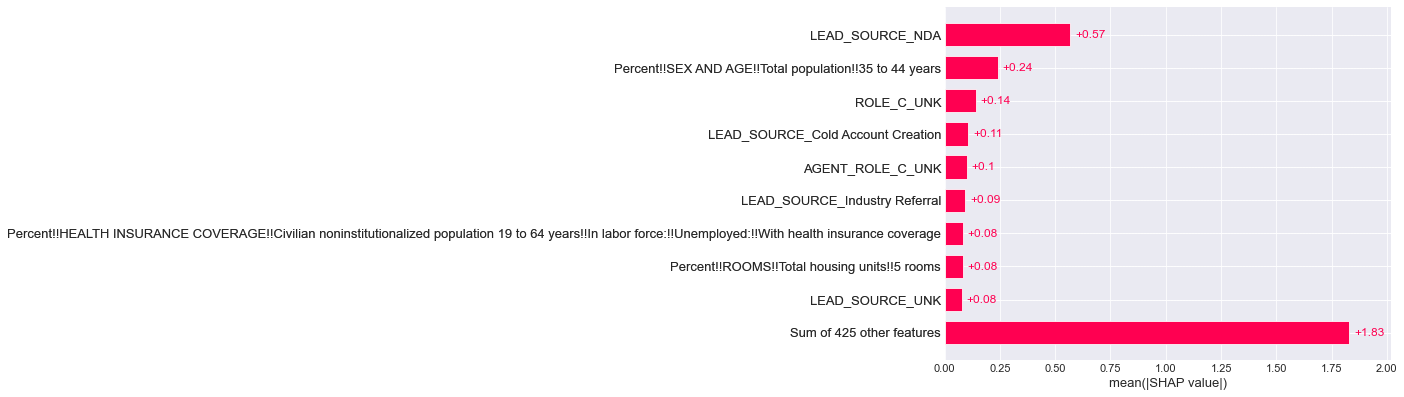

In [ ]:
shap.plots.bar(shap_values)

## lift and gain

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.817


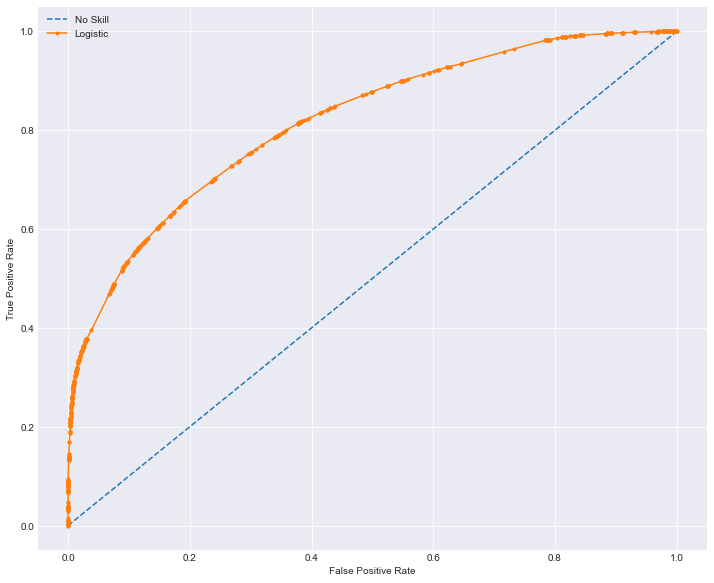

In [ ]:
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_train))]
# predict probabilities
xgb_probs = base_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_train, ns_probs)
xgb_auc = roc_auc_score(y_train, xgb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (xgb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_train, xgb_probs)

plt.figure(figsize=(12, 10))

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

# show the plot
plt.show()

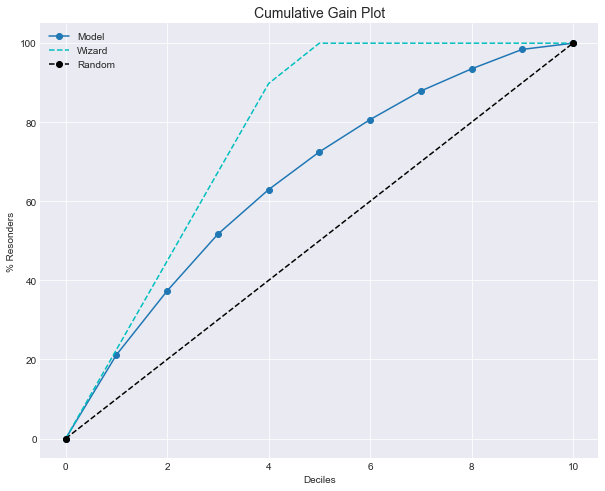

In [ ]:
y_test_pred_prob = base_model.predict_proba(X_test)
kds.metrics.plot_cumulative_gain(y_test, y_test_pred_prob[:,1])

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.926,0.999,0.971,429.0,404.0,25.0,190.9,429,94.172,429.0,404.0,429,25.0,10.014,21.163,22.472,1.053,20.110,2.113
1,2,0.658,0.926,0.771,428.0,309.0,119.0,190.9,428,72.196,857.0,713.0,857,144.0,20.005,37.349,44.893,6.063,31.286,1.867
2,3,0.549,0.658,0.626,429.0,274.0,155.0,190.9,429,63.869,1286.0,987.0,1286,299.0,30.019,51.702,67.365,12.589,39.113,1.722
3,4,0.433,0.549,0.495,428.0,215.0,213.0,190.9,428,50.234,1714.0,1202.0,1714,512.0,40.009,62.965,89.785,21.558,41.407,1.574
4,5,0.400,0.433,0.425,428.0,182.0,246.0,190.9,195,42.523,2142.0,1384.0,1909,758.0,50.000,72.499,100.000,31.916,40.583,1.450
5,6,0.311,0.400,0.363,429.0,156.0,273.0,190.9,0,36.364,2571.0,1540.0,1909,1031.0,60.014,80.671,100.000,43.411,37.260,1.344
6,7,0.267,0.311,0.289,428.0,138.0,290.0,190.9,0,32.243,2999.0,1678.0,1909,1321.0,70.005,87.899,100.000,55.621,32.278,1.256
7,8,0.214,0.267,0.227,429.0,107.0,322.0,190.9,0,24.942,3428.0,1785.0,1909,1643.0,80.019,93.504,100.000,69.179,24.325,1.169
8,9,0.140,0.214,0.204,428.0,94.0,334.0,190.9,0,21.963,3856.0,1879.0,1909,1977.0,90.009,98.428,100.000,83.242,15.186,1.094
9,10,0.003,0.138,0.058,428.0,30.0,398.0,190.9,0,7.009,4284.0,1909.0,1909,2375.0,100.000,100.000,100.000,100.000,0.000,1.000


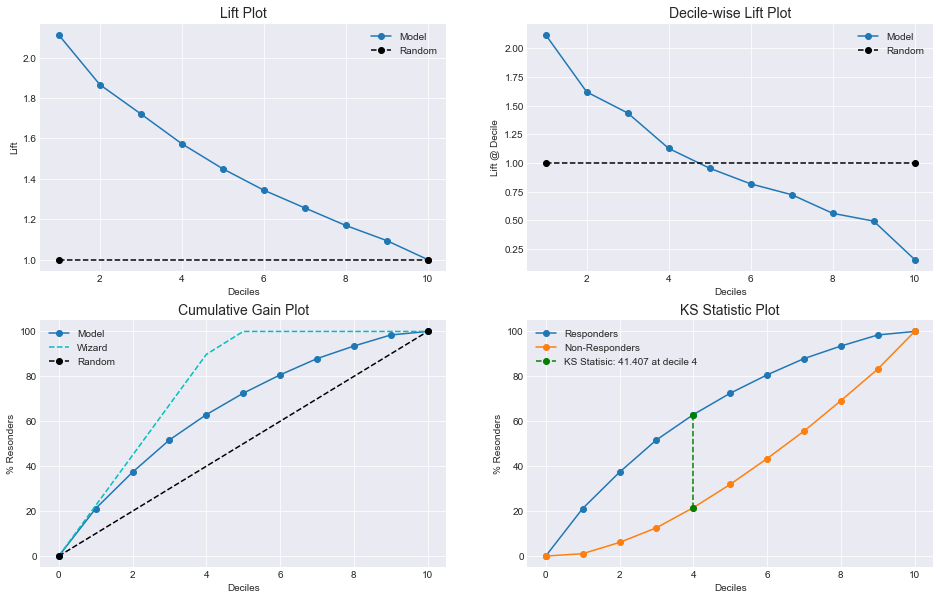

In [ ]:
kds.metrics.report(y_test, y_test_pred_prob[:,1])